In [1]:
import pandas as pd
import openai
import json
from collections import Counter
import os
from dotenv import load_dotenv
import re

In [2]:
# ID Filter for packages which have at least 2 unique headlines
packages_df = pd.read_csv('upworthy_experiment_packages.csv', low_memory=False)
packages_df = packages_df.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
valid_ids = packages_df.groupby('clickability_test_id').filter(lambda x: x['headline'].nunique() >= 4)['clickability_test_id'].unique()
sample_packages = 5000
sampled_ids = pd.Series(valid_ids).sample(sample_packages, random_state=123)
#sampled_df = packages_df[packages_df['clickability_test_id'].isin(sampled_ids)]
unique_df = packages_df[packages_df['clickability_test_id'].isin(valid_ids)]
print(len(unique_df))
better_df = unique_df.dropna()
print(len(better_df))

49545
0


In [3]:
unique_df[:10]

,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week,created
0,2014-11-20 11:33:26.475,2016-04-02 16:25:54.046,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,"Let’s See … Hire Cops, Pay Teachers, Buy Books...",<p>Iff you start with the basic fact that inno...,let-s-see-hire-cops-pay-teachers-buy-books-for...,546dce659ad54ec65b000041,3118,8,0.1,False,False,NaN,NaN,201446,2014-11-20 11:33:26.475
1,2014-11-20 15:00:01.032,2016-04-02 16:25:54.128,546e01d626714c6c4400004e,Things that matter. Pass 'em on.,People Sent This Lesbian Questions And Her Rai...,<p>I'll be honest. I've wondered about 7.</p>,people-sent-this-lesbian-questions-and-her-rai...,546d1b4bfd3617f091000041,4587,130,55.8,False,False,NaN,NaN,201446,2014-11-20 15:00:01.032
2,2014-11-20 11:33:51.973,2016-04-02 16:25:54.069,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,$3 Million Is What It Takes For A State To Leg...,<p>Iff you start with the basic fact that inno...,3-million-is-what-it-takes-for-a-state-to-lega...,546dce659ad54ec65b000041,3017,19,26.9,False,False,NaN,NaN,201446,2014-11-20 11:33:51.973
3,2014-11-20 11:34:12.107,2016-04-02 16:25:54.049,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,The Fact That Sometimes Innocent People Are Ex...,<p>Iff you start with the basic fact that inno...,the-fact-that-sometimes-innocent-people-are-ex...,546dce659ad54ec65b000041,2974,26,100.0,True,False,NaN,NaN,201446,2014-11-20 11:34:12.107
4,2014-11-20 11:34:33.935,2016-04-02 16:25:54.072,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,Reason #351 To End The Death Penalty: It Costs...,<p>Iff you start with the basic fact that inno...,reason-351-to-end-the-death-penalty-it-costs-3...,546dce659ad54ec65b000041,3050,10,0.2,False,False,NaN,NaN,201446,2014-11-20 11:34:33.935
5,2014-11-20 11:34:48.474,2016-04-02 16:25:54.052,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,"I Was Already Against The Death Penalty, But N...",<p>Iff you start with the basic fact that inno...,i-was-already-against-the-death-penalty-but-no...,546dce659ad54ec65b000041,3061,20,32.0,False,False,NaN,NaN,201446,2014-11-20 11:34:48.474
6,2014-11-20 11:36:09.896,2016-04-02 16:25:54.055,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,I'll Say It: It's Not OK For States To Legally...,<p>Iff you start with the basic fact that inno...,ill-say-it-its-not-ok-for-states-to-legally-mu...,546dce659ad54ec65b000041,2997,20,28.2,False,False,NaN,NaN,201446,2014-11-20 11:36:09.896
11,2014-11-20 15:48:53.77,2016-04-02 16:31:40.771,546e0d339ad54e667a00005a,Things that matter. Pass 'em on.,You Guys. Solar-Powered Boat Schools. Repeat. ...,<p>This is a pretty great idea for a TV show! ...,you-guys-solar-powered-boat-schools-repeat-sol...,546a84cc5b606a1fa0000022,4596,14,0.0,False,False,NaN,NaN,201446,2014-11-20 15:48:53.770
24,2014-11-20 15:49:14.3,2016-04-02 16:31:40.774,546e0d339ad54e667a00005a,Things that matter. Pass 'em on.,"They're Asking For $12,000. If I Give It To Th...",<p>This is a pretty great idea for a TV show! ...,theyre-asking-for-12-000-if-i-give-it-to-them-...,546a84cc5b606a1fa0000022,4556,27,1.4,False,False,NaN,NaN,201446,2014-11-20 15:49:14.300
35,2014-11-20 13:35:08.065,2016-04-02 16:25:54.156,546dee0c26714c0538000056,#PromotedPost Things that matter. Pass 'em on.,At First Glance It Just Looks Like A Bus. But ...,<p>Meet Amelia. Some might call her a business...,at-first-glance-it-just-looks-like-a-bus-but-i...,5465291f744884eb36000042,4574,57,0.7,False,False,NaN,NaN,201446,2014-11-20 13:35:08.065


In [4]:
simpler_df = unique_df[["clickability_test_id", "headline", "impressions", "clicks", "winner", "first_place"]]

In [4]:
# save this to a csv file
simpler_df.to_csv('upworthy_experiment_simpler.csv')

In [8]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch

# Load pre-trained model and tokenizer
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to predict CTR
def predict_ctr(headline):
    # Encode the headline
    inputs = tokenizer(headline, return_tensors='pt')

    # Get model's output
    outputs = model(**inputs)

    # We use the [CLS] output as the headline's embedding
    headline_embedding = outputs.last_hidden_state[:, 0, :]

    # Here you can use the headline_embedding to predict the CTR
    # For example, you can pass it through a linear layer
    # Note: You need to train this linear layer (or any other model) on your task
    ctr_pred = torch.nn.Linear(headline_embedding.size(-1), 1)(headline_embedding)

    return ctr_pred

# Test the function
headline = "This is a test headline"
ctr_pred = predict_ctr(headline)

print(ctr_pred)

/Users/egeozin/.pyenv/versions/3.8.10/envs/gpt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

tensor([[0.0766]], grad_fn=<AddmmBackward0>)


In [9]:
# get the first headline from sampled_df
headline = sampled_df['headline'].iloc[0]
ctr_pred = predict_ctr(headline)
print(ctr_pred)

tensor([[-0.1280]], grad_fn=<AddmmBackward0>)


# OpenAI embeddings

In [9]:
# imports
import pandas as pd
import numpy as np
from ast import literal_eval

import pandas as pd
import tiktoken

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [5]:
import os

openai.api_key = os.getenv('OPENAI_API_KEY')

In [10]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [8]:
encoding = tiktoken.get_encoding(embedding_encoding)
# omit reviews that are too long to embed
simpler_df["n_tokens"] = simpler_df.headline.apply(lambda x: len(encoding.encode(x)))
filter_df = simpler_df[simpler_df.n_tokens <= max_tokens]
len(filter_df)

/var/folders/sv/tnwsf5gj4_j28jzp5zdw7gj80000gn/T/ipykernel_74185/3088811136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simpler_df["n_tokens"] = simpler_df.headline.apply(lambda x: len(encoding.encode(x)))


49545

# Here you compute the Embeddings

In [5]:
# read in the embedding data
filter_df = pd.read_csv("ablation_data_openai_ada_002.csv")

Average Clicks: 46.56183267736401
Standard Deviation of Clicks: 40.20707562050527
count    49545.000000
mean        46.561833
std         40.207076
min          0.000000
25%         21.000000
50%         35.000000
75%         59.000000
max        701.000000
Name: clicks, dtype: float64


<Axes: >

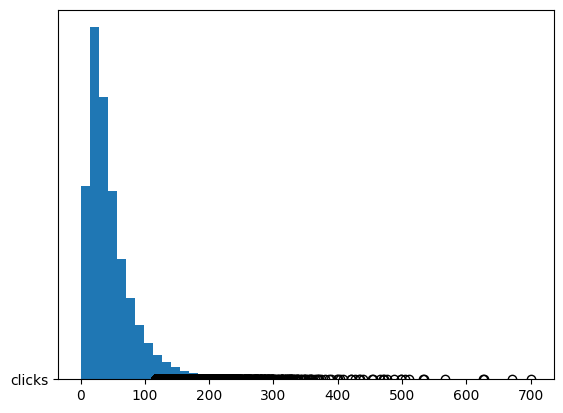

In [25]:
# Calculate the average number of clicks
average_clicks = filter_df['clicks'].mean()
print(f'Average Clicks: {average_clicks}')

# Calculate the standard deviation to understand the spread
std_dev_clicks = filter_df['clicks'].std()
print(f'Standard Deviation of Clicks: {std_dev_clicks}')

# Describe the distribution
distribution = filter_df['clicks'].describe()
print(distribution)

# Histogram to visualize the distribution
filter_df['clicks'].hist(bins=50)

# Show a boxplot to visualize the distribution and potential outliers
filter_df['clicks'].plot(kind='box', vert=False)

In [6]:
filter_df[:10]

,clickability_test_id,headline,impressions,clicks,winner,first_place,n_tokens,embedding
0,546dd17e26714c82cc00001c,"Let’s See … Hire Cops, Pay Teachers, Buy Books...",3118,8,False,False,25,"[0.01483243890106678, -0.0056637790985405445, ..."
1,546e01d626714c6c4400004e,People Sent This Lesbian Questions And Her Rai...,4587,130,False,False,16,"[-0.009504910558462143, -0.013010174036026001,..."
2,546dd17e26714c82cc00001c,$3 Million Is What It Takes For A State To Leg...,3017,19,False,False,15,"[0.013443034142255783, 0.004486433696001768, 0..."
3,546dd17e26714c82cc00001c,The Fact That Sometimes Innocent People Are Ex...,2974,26,False,True,21,"[0.00983955804258585, -0.004824853036552668, -..."
4,546dd17e26714c82cc00001c,Reason #351 To End The Death Penalty: It Costs...,3050,10,False,False,17,"[0.0182014349848032, -0.003413585713133216, -0..."
5,546dd17e26714c82cc00001c,"I Was Already Against The Death Penalty, But N...",3061,20,False,False,22,"[0.00297338399104774, -0.016174687072634697, 0..."
6,546dd17e26714c82cc00001c,I'll Say It: It's Not OK For States To Legally...,2997,20,False,False,17,"[0.009097990579903126, -0.0022397483699023724,..."
7,546e0d339ad54e667a00005a,You Guys. Solar-Powered Boat Schools. Repeat. ...,4596,14,False,False,21,"[0.013811718672513962, -0.022465644404292107, ..."
8,546e0d339ad54e667a00005a,"They're Asking For $12,000. If I Give It To Th...",4556,27,False,False,22,"[-0.0138528598472476, -0.009457114152610302, -..."
9,546dee0c26714c0538000056,At First Glance It Just Looks Like A Bus. But ...,4574,57,False,False,21,"[0.019017867743968964, 0.00322405225597322, 0...."


In [11]:
filter_df['embedding'] = filter_df['embedding'].apply(literal_eval)

In [13]:
# Find the clickability_test_id's where any of the embeddings or headlines are missing
invalid_ids = filter_df[filter_df['embedding'].isnull() | filter_df['headline'].isnull()]['clickability_test_id'].unique()

In [23]:
# Get unique clickability_test_id's and split them into train and test sets
unique_ids = filter_df['clickability_test_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Create train and test dataframes based on the split ids
train_df = filter_df[filter_df['clickability_test_id'].isin(train_ids)]
test_df = filter_df[filter_df['clickability_test_id'].isin(test_ids)]

# Split the data into features (X) and target (y)
X_train = pd.DataFrame(train_df['embedding'].to_list())
y_train = train_df['first_place']

X_test = pd.DataFrame(test_df['embedding'].to_list())
y_test = test_df['first_place']

In [17]:
print(len(X_train), len(X_test))

39561 9984
3.9624399038461537


In [28]:
# train random forest classifier
#first_clf = RandomForestClassifier(n_estimators=100)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

In [30]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

       False       0.81      0.95      0.88      7899
        True       0.48      0.16      0.24      2085

    accuracy                           0.79      9984
   macro avg       0.65      0.56      0.56      9984
weighted avg       0.74      0.79      0.74      9984



In [31]:
from sklearn.metrics import roc_auc_score

# Compute AUROC
auroc = roc_auc_score(y_test, probas[:, 1])
print('AUROC:', auroc)

AUROC: 0.5635453657582858


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming filter_df is your DataFrame and already contains the 'embedding' column
# Get unique clickability_test_id's and split them into train and test sets
unique_ids = filter_df['clickability_test_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Create train and test dataframes based on the split ids
train_df = filter_df[filter_df['clickability_test_id'].isin(train_ids)]
test_df = filter_df[filter_df['clickability_test_id'].isin(test_ids)]

# Split the data into features (X) and target (y)
X_train = pd.DataFrame(train_df['embedding'].to_list())
y_train = train_df['clicks']  # Target is now 'clicks' instead of 'first_place'

X_test = pd.DataFrame(test_df['embedding'].to_list())
y_test = test_df['clicks']

In [24]:
len(X_train), len(X_test)

(39561, 9984)

In [18]:
# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
# Predict on the test data
clicks_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, clicks_pred)
r2 = r2_score(y_test, clicks_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1115.2623356284787
R-squared: 0.30439288758043026


In [20]:
from joblib import dump

# Save the model to a file
dump(regressor, 'random_forest_regressor.joblib')

['random_forest_regressor.joblib']

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, clicks_pred)
rmse = mean_squared_error(y_test, clicks_pred, squared=False)
mae = mean_absolute_error(y_test, clicks_pred)
r2 = r2_score(y_test, clicks_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1115.2623356284787
Root Mean Squared Error: 33.39554364924276
Mean Absolute Error: 22.711403177376507
R-squared: 0.30439288758043026


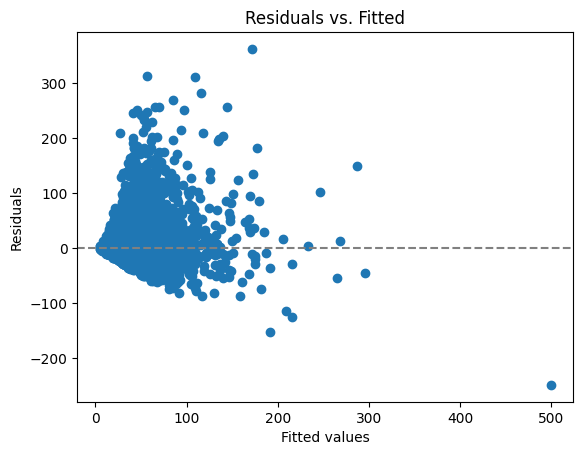

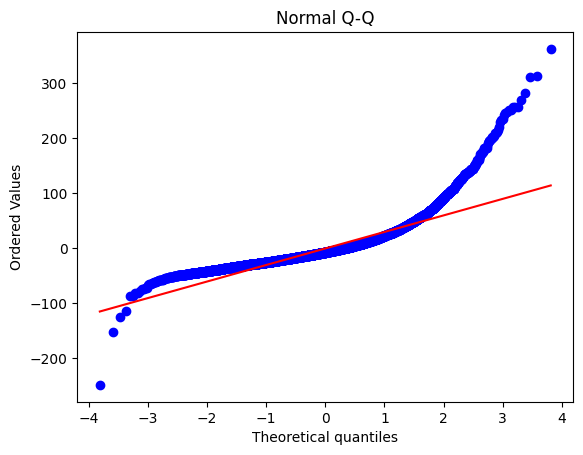

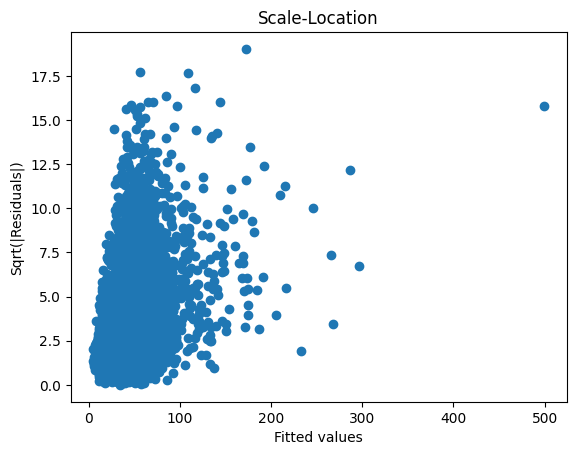

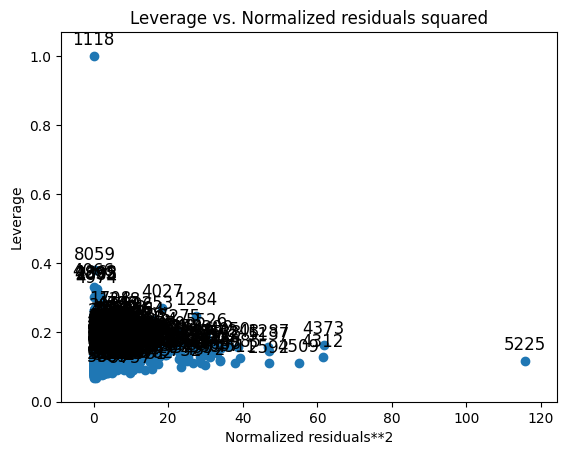

In [23]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Calculate residuals
residuals = y_test - clicks_pred

# Residuals vs. Fitted Plot
plt.scatter(clicks_pred, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.show()

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q')
plt.show()

# Scale-Location Plot
plt.scatter(clicks_pred, np.sqrt(np.abs(residuals)))
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Residuals|)')
plt.title('Scale-Location')
plt.show()

# Residuals vs. Leverage Plot
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import statsmodels.api as sm

y_test = y_test.reset_index(drop=True)
X_test_with_const = sm.add_constant(X_test.reset_index(drop=True))

# Now create the OLS model
model = sm.OLS(y_test, X_test_with_const)
fit = model.fit()

# Continue with the leverage plot
plot_leverage_resid2(fit)
plt.show()

## IGNORE THIS FOR NOW

In [ ]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

# Load pre-trained model and tokenizer
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a dataset
class HeadlineDataset(Dataset):
    def __init__(self, headlines, winners):
        self.headlines = headlines
        self.winners = winners

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        headline = self.headlines[idx]
        winner = self.winners[idx]
        return headline, winner

# Create a dataloader
headlines = sampled_df['headline'].tolist()
winners = sampled_df['winner'].astype(int).tolist()  # Convert winners to integers
dataset = HeadlineDataset(headlines, winners)
dataloader = DataLoader(dataset, batch_size=32)

# Define a simple linear model
linear_model = nn.Linear(model.config.dim, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_model.parameters())

# Train the model
for epoch in range(10):  # Number of epochs
    for i, (headlines, winners) in enumerate(dataloader):
        # Encode the headlines
        inputs = tokenizer(headlines, return_tensors='pt', padding=True, truncation=True, max_length=512)

        # Get model's output
        outputs = model(**inputs)

        # We use the [CLS] output as the headline's embedding
        headline_embeddings = outputs.last_hidden_state[:, 0, :]

        # Forward pass through the linear model
        winner_preds = linear_model(headline_embeddings)

        # Compute the loss
        loss = criterion(winner_preds, winners.unsqueeze(1).float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 100 steps
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')